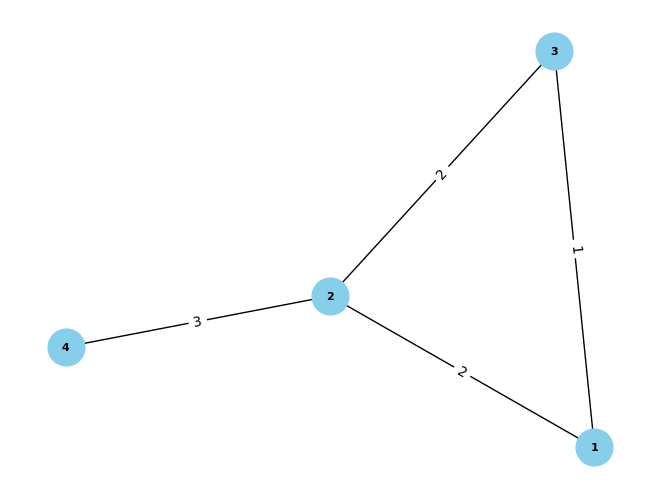

In [111]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# Create a graph with 10 nodes
G = nx.Graph()

# Add nodes to the graph
nodes = 4

G.add_nodes_from(range(1, nodes))
G.add_edge(1, 2, weight=2)
G.add_edge(1, 3, weight=1)
G.add_edge(3, 2, weight=2)
G.add_edge(2, 4, weight=3)

# Plot the graph with weights
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8)

# Add edge labels with weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

## 1. Weight matrix

In [112]:
weight_array = nx.adjacency_matrix(G, weight='weight').todense()
print(weight_array)

[[0 2 1 0]
 [2 0 2 3]
 [1 2 0 0]
 [0 3 0 0]]


In [113]:
start_node = 4
shortest_paths = nx.shortest_path_length(G, source=start_node, weight='weight')
print(f"Shortest distances from node {start_node}: {shortest_paths}")

Shortest distances from node 4: {4: 0, 2: 3, 1: 5, 3: 5}


In [114]:
np.random.seed(41)
nod_numbers = len(G.nodes())

probabilities = np.round(np.random.rand(nod_numbers, nod_numbers), decimals=2)
prob_array = np.where(weight_array > 0, probabilities, 0)
print(prob_array)

[[0.   0.05 0.68 0.  ]
 [0.12 0.   0.19 0.67]
 [0.92 0.42 0.   0.  ]
 [0.   0.32 0.   0.  ]]


In [115]:
def infection_matrix(net):
    
    num_nodes = len(net.nodes())
    infection_array = np.zeros((num_nodes, num_nodes), dtype=float)
                
    return infection_array

infect_array = infection_matrix(G)
print(infect_array)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [119]:
def update_time(times_matrix, seed_node):
    
    values = 0
    track = np.array([seed_node - 1])
    
    # What was the min value of the arrange greater than 0 (it-self)--> faster transmission
    indeces = np.where(times_matrix[(seed_node - 1), :] >= 1)
    values = times_matrix[(seed_node - 1), indeces]

    # Check if any new number is not in the existing array
    new_numbers = np.setdiff1d(indeces[0], track)
    track = np.concatenate((track, new_numbers))

    # Update the infection time
    for v, k in zip(values[0], track[1:]):
        
        update = times_matrix[k, :]
        update[update > 0] += v

        # Add the update
        times_matrix[k, :] = update

        # Update indeces and values for the next iteration
        indeces = np.where(times_matrix[k, :] >= 1)
        values = times_matrix[k, indeces]

        # Check if any new number is not in the existing array THE NODE == INDEX
        new_numbers = np.setdiff1d(indeces[0], track)
        #print("new_numbers ROW", new_numbers)

        if new_numbers.size > 0:
            v = times_matrix[k, new_numbers]

            update = times_matrix[new_numbers, :]
            update[update > 0] += v[0]
            # Add the update
            times_matrix[new_numbers, :] = update

            # Concatenate values and times_matrix[k, new_numbers]
            track = np.concatenate((track, new_numbers))

    return track  

def infection(f, track, prob_array, infect_array):
    p = f
    infection_row = np.where(prob_array[track[0], :] >= p, 1, 0)
    infect_array[track[0],:] = infection_row

    for i in infection_row[1:]: # 1, 0, 0, 0
        if i == 1:
            for j in track[1:]: # ..., 1, 1
                infect_row = np.where(prob_array[j, :] >= p, 1, 0)
                infect_array[j,:] = infect_row

                cols = np.where(infect_array[j,:] == 1)
                
                # Check if any new number is not in the existing array
                new_numbers = np.setdiff1d(cols, track)

                # Append the new numbers to the existing array
                track = np.append(track, new_numbers)
        else:
            pass

    return infect_array     


def update_time_prob(times_matrix, infection_matrix, seed_node):
    
    times_matrix = times_matrix * infection_matrix
    
    values = 0
    track = np.array([seed_node - 1])
    #print("Initial TRACK:", track)

    # What was the min value of the arrange greater than 0 (it-self)--> faster transmission
    indeces = np.where(times_matrix[(seed_node - 1), :] >= 1)
    values = times_matrix[(seed_node - 1), indeces]

    # Check if any new number is not in the existing array
    new_numbers = np.setdiff1d(indeces[0], track)
    track = np.concatenate((track, new_numbers))

    #print("GO INSIDE")
    # Update the infection time
    for v, k in zip(values[0], track[1:]):
        
        update = times_matrix[k, :]
        update[update > 0] += v

        # Add the update
        times_matrix[k, :] = update

        # Update indeces and values for the next iteration
        indeces = np.where(times_matrix[k, :] >= 1)
        values = times_matrix[k, indeces]

        # Check if any new number is not in the existing array THE NODE == INDEX
        new_numbers = np.setdiff1d(indeces[0], track)
        #print("new_numbers ROW", new_numbers)

        if new_numbers.size > 0:
            print("value ", times_matrix[k, new_numbers])  # aca el Value
            v = times_matrix[k, new_numbers]

            update = times_matrix[new_numbers, :]
            update[update > 0] += v[0]
            # Add the update
            times_matrix[new_numbers, :] = update

            # Concatenate values and times_matrix[k, new_numbers]
            track = np.concatenate((track, new_numbers))
            
    accumulated_sums = {}

    # Initialize accumulated sum variable
    accumulated_sum = 0

    # Iterate through the shortest path lengths
    for node, distance in shortest_paths.items():
        # Add the distance to the accumulated sum
        accumulated_sum += distance

        # Store the accumulated sum in the dictionary
        accumulated_sums[node] = accumulated_sum
        
        
    return times_matrix, track, accumulated_sums    

In [120]:
seed_node = 4
times_matrix = nx.adjacency_matrix(G, weight='weight').todense()
print("Original times_matrix:")
print(times_matrix)
print(infection_matrix)

Original times_matrix:
[[0 2 1 0]
 [2 0 2 3]
 [1 2 0 0]
 [0 3 0 0]]
<function infection_matrix at 0x7f6ae7b69ab0>


In [121]:
track_nodes = update_time(times_matrix, seed_node)

print("\nUpdated track:")
print(track_nodes)


Updated track:
[3 1 0 2]


In [122]:
f = 0.1
infection_array = infection(f, track_nodes, prob_array, infect_array)
print(infection_array)

[[0. 0. 1. 0.]
 [1. 0. 1. 1.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [125]:
times_array, track_array, accumulated_times  = update_time_prob(times_matrix, infection_array, seed_node)

value  [8. 8.]


In [126]:
times_array

array([[ 0.,  0., 14.,  0.],
       [ 8.,  0.,  8.,  9.],
       [14., 15.,  0.,  0.],
       [ 0.,  3.,  0.,  0.]])

In [127]:
track_array

array([3, 1, 0, 2])

In [128]:
accumulated_times

{4: 0, 2: 3, 1: 8, 3: 13}

In [129]:
track_array

array([3, 1, 0, 2])

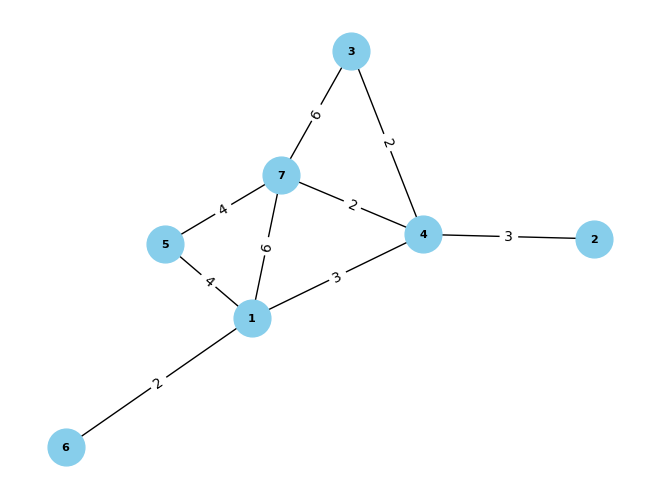

In [130]:
# Create a graph with 10 nodes
G = nx.Graph()

# Add nodes to the graph
nodes = 8

G.add_nodes_from(range(1, nodes))
G.add_edge(2, 4, weight=3)
G.add_edge(4, 3, weight=2)
G.add_edge(3, 7, weight=6)
G.add_edge(7, 1, weight=6)
G.add_edge(7, 4, weight=2)
G.add_edge(7, 5, weight=4)
G.add_edge(1, 6, weight=2)
G.add_edge(5, 1, weight=4)
G.add_edge(4, 1, weight=3)

# Plot the graph with weights
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8)

# Add edge labels with weights
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

In [173]:
weight_array = nx.adjacency_matrix(G, weight='weight').todense()


In [174]:
np.random.seed(41)
nod_numbers = len(G.nodes())

probabilities = np.round(np.random.rand(nod_numbers, nod_numbers), decimals=2)
prob_array = np.where(weight_array > 0, probabilities, 0)


In [175]:
def infection_matrix(net):
    
    num_nodes = len(net.nodes())
    infection_array = np.zeros((num_nodes, num_nodes), dtype=float)
                
    return infection_array

infect_array = infection_matrix(G)


In [176]:
seed_node = 4
times_matrix = nx.adjacency_matrix(G, weight='weight').todense()


In [178]:
track_nodes = update_time(times_matrix, seed_node)
print("\nUpdated track:")



Updated track:


In [179]:
f = 0.45
infection_array = infection(f, track_nodes, prob_array, infect_array)
#print(infection_array)

In [160]:
times_array, track_array, accumulated_times  = update_time_prob(times_matrix, infection_array, seed_node)

value  [11.]
value  [10.]


In [161]:
track_array

array([3, 0, 6, 5, 4])

In [164]:
values_array2 = np.array(list(accumulated_times.values()))

In [172]:
track_array

array(['3', '0', '6', '5', '4'], dtype='<U1')

ValueError: x and y must have same first dimension, but have shapes (5,) and (7,)

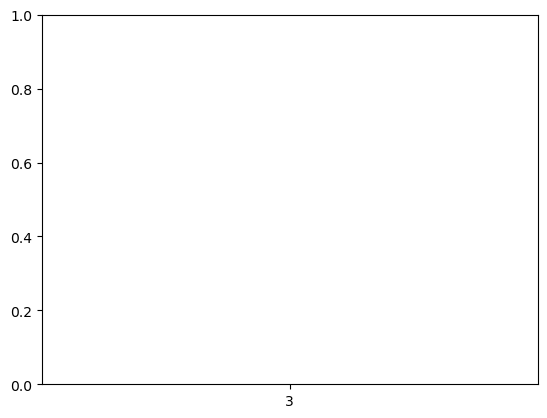

In [169]:
# Your NumPy array
track_array = text_array = np.vectorize(str)(track_array)
track_array2 = text_array = np.vectorize(str)(track_array)

# Plot the line with characters
#plt.plot(track_array, values_array, marker='o', linestyle='-')
plt.plot(track_array2, values_array2, marker='o', linestyle='-')
# Add labels and title
plt.xlabel('Nodes')
plt.ylabel('Values (Mapped to Characters)')
plt.title('Line Plot of Categorized Data')

# Show the plot
plt.show()


In [155]:
char_array

array(['D', 'A', 'B', 'C', 'G', 'F', 'E'], dtype='<U1')